## Loss Function(Pytorch ver.)
발표자 : 통합과정 최찬혁

앞서서 우리는 tensorflow에는 categorical cross entropy loss 및 sparse categorical cross entropy loss가 있음을 알 수 있었습니다.

그러나 pytorch에는 sparse categorical cross entropy loss가 없습니다.

그렇다면 pytorch에서는 정수형 label을 이용해야 되는 지 one-hot encodding 적용된 label을 이용해야 되는 지 살펴보도록 하겠습니다.

## Import pakage
필요한 패키지를 불러옵니다.

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import tensorflow as tf


## Download data
데이터를 다운로드합니다.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_valid = x_train[:50000], x_train[50000:]
y_train, y_valid = y_train[:50000], y_train[50000:]
x_train = x_train.reshape(50000,28*28)/255
x_valid = x_valid.reshape(-1, 28*28)/255
x_test  = x_test.reshape(-1, 28*28)/255

y_train_one_hot = np.eye(10)[y_train]
y_valid_one_hot = np.eye(10)[y_valid]

11490434/11490434 [==============================] - 1s 0us/step


## Custom dataset

pytorch에서는 dataloader를 만들어서 학습을 진행해야 됩니다.

dataloader는 dataset을 먼저 구성해서 완성해야 됩니다. 이에 CustomDataset을 만듭니다.

다만, 정수형 label 및 one-hot encodding label에 따라 dataset을 각각 만들어야 됩니다.

In [3]:
class CustomTrainDataset(Dataset):
    def __init__(self):
        self.x_data = torch.from_numpy(x_train)
        self.x_data = self.x_data.type(torch.FloatTensor)
        self.y_data = torch.from_numpy(y_train)
        self.y_data = self.y_data.type(torch.LongTensor)

    # 총 데이터의 개수를 리턴
    def __len__(self):
        return len(self.x_data)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [4]:
class CustomValidDataset(Dataset):
    def __init__(self):
        self.x_data = torch.from_numpy(x_valid)
        self.x_data = self.x_data.type(torch.FloatTensor)
        self.y_data = torch.from_numpy(y_valid)
        self.y_data = self.y_data.type(torch.LongTensor)

    # 총 데이터의 개수를 리턴
    def __len__(self):
        return len(self.x_data)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [5]:
class CustomTestDataset(Dataset):
    def __init__(self):
        self.x_data = torch.from_numpy(x_test)
        self.x_data = self.x_data.type(torch.FloatTensor)
        self.y_data = torch.from_numpy(y_test)
        self.y_data = self.y_data.type(torch.LongTensor)

    # 총 데이터의 개수를 리턴
    def __len__(self):
        return len(self.x_data)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [6]:
class CustomTrainDataset_one_hot(Dataset):
    def __init__(self):
        self.x_data = torch.from_numpy(x_train)
        self.x_data = self.x_data.type(torch.FloatTensor)
        self.y_data = torch.from_numpy(y_train_one_hot)
        self.y_data = self.y_data.type(torch.FloatTensor)

    # 총 데이터의 개수를 리턴
    def __len__(self):
        return len(self.x_data)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [7]:
class CustomValidDataset_one_hot(Dataset):
    def __init__(self):
        self.x_data = torch.from_numpy(x_valid)
        self.x_data = self.x_data.type(torch.FloatTensor)
        self.y_data = torch.from_numpy(y_valid_one_hot)
        self.y_data = self.y_data.type(torch.FloatTensor)

    # 총 데이터의 개수를 리턴
    def __len__(self):
        return len(self.x_data)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [8]:
trainset = CustomTrainDataset()
validset = CustomValidDataset()
testset = CustomTestDataset()

trainset_one_hot = CustomTrainDataset_one_hot()
validset_one_hot = CustomValidDataset_one_hot()

## Dataloader
위에서 구성된 Customdataset을 이용해서 dataloader를 만듭니다.

In [9]:
trainloader = DataLoader(trainset, batch_size=250, shuffle=True)
validloader = DataLoader(validset, batch_size=250, shuffle=True)
testloader = DataLoader(testset, batch_size=250, shuffle=True)

trainloader_one_hot = DataLoader(trainset_one_hot, batch_size=250, shuffle=True)
validloader_one_hot = DataLoader(validset_one_hot, batch_size=250, shuffle=True)

## Model

기본적인 MLP 모델을 만듭니다.

pytorch에서는 layer 안에 활성화함수를 넣을 수 없으므로 layer 사이에 활성화함수 layer를 넣어줘야 됩니다.

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear = nn.Linear(784,100)
        self.sigmoid = nn.Sigmoid()
        self.final = nn.Linear(100, 10)

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        x = self.final(x)
        return x


## Useful function

학습 과정, 검증 과정 함수를 만듭니다.

train_loop : dataloader, model, loss function, optimizer를 입력받아서 1epoch 학습합니다.

test_loop : dataloader, model, loss function을 입력받아서 loss function 값 및 accuracy를 리턴합니다.

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [12]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    total_loss /= num_batches
    correct /= size
    print("loss : %.4f" %total_loss)
    print("accuracy : ", correct)
    return total_loss, correct

## Setting hyperparameters

In [13]:
learning_rate = 0.01
MAX_EPOCHS = 100

## Model1 (integer form label)

In [14]:
model1 = Model()
optimizer1 = torch.optim.SGD(model1.parameters(), lr = learning_rate)
loss_fn =  torch.nn.CrossEntropyLoss()


In [15]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

for epoch in range(MAX_EPOCHS):
    train_loop(trainloader, model1, loss_fn, optimizer1)
    print("Epoch #", epoch+1, " Done!!")
    print("Trainset")
    tmp1, tmp2 = test_loop(trainloader, model1, loss_fn)
    print("\nValidationset")
    tmp3, tmp4 = test_loop(validloader, model1, loss_fn)
    train_loss.append(tmp1)
    valid_loss.append(tmp3)
    train_acc.append(tmp2)
    valid_acc.append(tmp4)
    print("\n")



Epoch # 1  Done!!
Trainset
loss : 2.2566
accuracy :  0.2094

Validationset
loss : 2.2571
accuracy :  0.2026


Epoch # 2  Done!!
Trainset
loss : 2.1999
accuracy :  0.48662

Validationset
loss : 2.1989
accuracy :  0.5029


Epoch # 3  Done!!
Trainset
loss : 2.1294
accuracy :  0.51358

Validationset
loss : 2.1274
accuracy :  0.5226


Epoch # 4  Done!!
Trainset
loss : 2.0395
accuracy :  0.60246

Validationset
loss : 2.0360
accuracy :  0.6259


Epoch # 5  Done!!
Trainset
loss : 1.9291
accuracy :  0.62832

Validationset
loss : 1.9228
accuracy :  0.6496


Epoch # 6  Done!!
Trainset
loss : 1.8021
accuracy :  0.65488

Validationset
loss : 1.7935
accuracy :  0.6736


Epoch # 7  Done!!
Trainset
loss : 1.6677
accuracy :  0.67396

Validationset
loss : 1.6553
accuracy :  0.6938


Epoch # 8  Done!!
Trainset
loss : 1.5358
accuracy :  0.69006

Validationset
loss : 1.5202
accuracy :  0.7095


Epoch # 9  Done!!
Trainset
loss : 1.4134
accuracy :  0.71266

Validationset
loss : 1.3939
accuracy :  0.7339


Ep

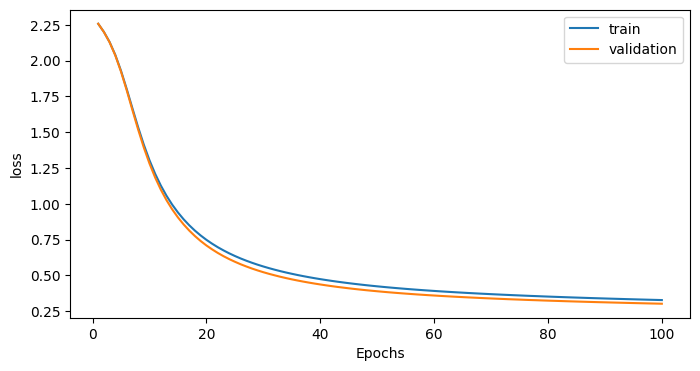

In [16]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, MAX_EPOCHS+1), train_loss, label='train')
plt.plot(np.arange(1, MAX_EPOCHS+1), valid_loss, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

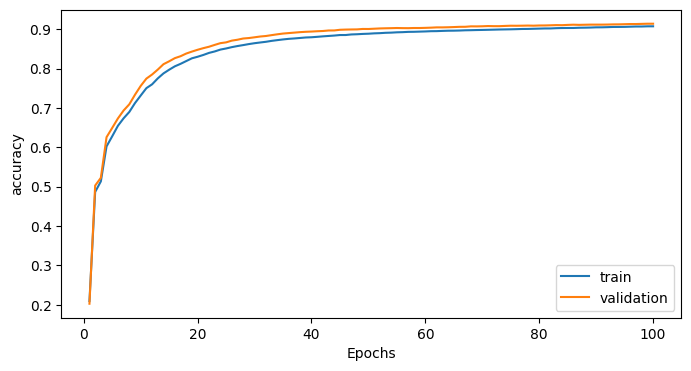

In [17]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, MAX_EPOCHS+1), train_acc, label='train')
plt.plot(np.arange(1, MAX_EPOCHS+1), valid_acc, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()

In [18]:
_, test_acc1 = test_loop(testloader, model1, loss_fn)
print("Accuracy for testset : ", test_acc1 * 100 , "%")

loss : 0.3124
accuracy :  0.9115
Accuracy for testset :  91.14999999999999 %


## Model2 (one-hot encodding label)

In [19]:
model2 = Model()
optimizer2 = torch.optim.SGD(model2.parameters(), lr = learning_rate)
loss_fn =  torch.nn.CrossEntropyLoss()

In [20]:
train_loss2 = []
valid_loss2 = []
train_acc2 = []
valid_acc2 = []

for epoch in range(MAX_EPOCHS):
    train_loop(trainloader_one_hot, model2, loss_fn, optimizer2)
    print("Epoch #", epoch+1, " Done!!")
    print("Trainset")
    tmp1, tmp2 = test_loop(trainloader, model2, loss_fn)
    print("\n Validationset")
    tmp3, tmp4 = test_loop(validloader, model2, loss_fn)
    train_loss2.append(tmp1)
    valid_loss2.append(tmp3)
    train_acc2.append(tmp2)
    valid_acc2.append(tmp4)
    print("\n")

Epoch # 1  Done!!
Trainset
loss : 2.2528
accuracy :  0.14862

 Validationset
loss : 2.2537
accuracy :  0.1409


Epoch # 2  Done!!
Trainset
loss : 2.1973
accuracy :  0.51242

 Validationset
loss : 2.1960
accuracy :  0.5253


Epoch # 3  Done!!
Trainset
loss : 2.1285
accuracy :  0.57646

 Validationset
loss : 2.1262
accuracy :  0.5921


Epoch # 4  Done!!
Trainset
loss : 2.0417
accuracy :  0.56358

 Validationset
loss : 2.0380
accuracy :  0.5777


Epoch # 5  Done!!
Trainset
loss : 1.9347
accuracy :  0.62846

 Validationset
loss : 1.9288
accuracy :  0.6493


Epoch # 6  Done!!
Trainset
loss : 1.8111
accuracy :  0.65272

 Validationset
loss : 1.8025
accuracy :  0.6711


Epoch # 7  Done!!
Trainset
loss : 1.6777
accuracy :  0.68508

 Validationset
loss : 1.6657
accuracy :  0.7031


Epoch # 8  Done!!
Trainset
loss : 1.5436
accuracy :  0.70692

 Validationset
loss : 1.5285
accuracy :  0.7286


Epoch # 9  Done!!
Trainset
loss : 1.4166
accuracy :  0.72958

 Validationset
loss : 1.3978
accuracy :  0

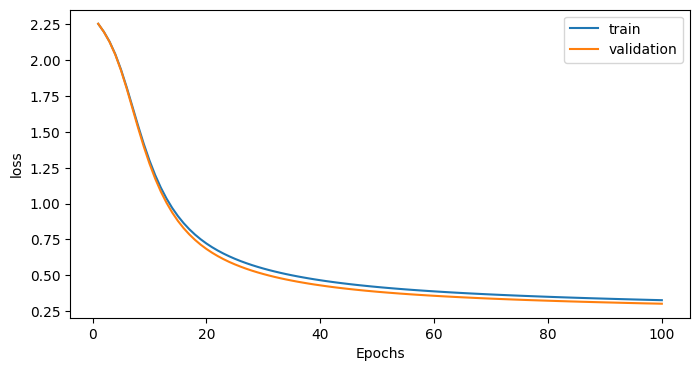

In [21]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, MAX_EPOCHS+1), train_loss2, label='train')
plt.plot(np.arange(1, MAX_EPOCHS+1), valid_loss2, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

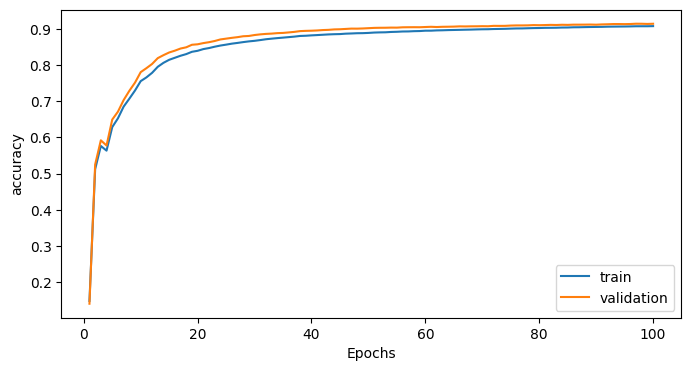

In [22]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, MAX_EPOCHS+1), train_acc2, label='train')
plt.plot(np.arange(1, MAX_EPOCHS+1), valid_acc2, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()

In [23]:
_, test_acc2 = test_loop(testloader, model2, loss_fn)
print("Accuracy for testset : ", test_acc2 * 100 , "%")

loss : 0.3116
accuracy :  0.9123
Accuracy for testset :  91.23 %


## Conclusion

결론적으로 tensorflow에서는 label에 따라서 loss function을 결정해주어야 정상적으로 작동함을 알 수 있었습니다.

- 정수형 label : sparse categorical cross entropy loss

- one-hot encodding label : categorical cross entropy loss

그러나 pytorch에서는 categorical cross entropy가 두가지 형태의 label 모두 잘 적용되는 것을 알 수 있습니다.